# GR00T Inference

This tutorial shows how to use the GR00T inference model to predict the actions from the observations, given a test dataset

In [46]:
import os
import torch
import gr00t

from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.model.policy import Gr00tPolicy

In [11]:
# change the following paths
MODEL_PATH = "/mloscratch/users/kalajdzi/track-hawk/checkpoints/checkpoint-5000"

DATASET_PATH = "/mloscratch/users/kalajdzi/track-hawk/data_track_hawk/dataset_drone_control"
EMBODIMENT_TAG = "new_embodiment"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Loading the model
The policy model is loaded from our checkpoint.
There are 2 new concepts here in the GR00T model:
 - modality config: This defines the keys in the dictionary used by the model. (e.g. `action`, `state`, `annotation`, `video`)
 - modality_transform: A sequence of transform which are used during dataloading

In [12]:
from gr00t.experiment.data_config import DATA_CONFIG_MAP

data_config =  DATA_CONFIG_MAP["track_hawk"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()

policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

# print out the policy model architecture
print(policy.model)

Model not found or avail in the huggingface hub. Loading from local path: /mloscratch/users/kalajdzi/track-hawk/checkpoints/checkpoint-5000
Loading pretrained dual brain from /mloscratch/users/kalajdzi/track-hawk/checkpoints/checkpoint-5000
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /mloscratch/users/kalajdzi/track-hawk/checkpoints/checkpoint-5000
Total number of DiT parameters:  537803776
Tune action head projector: True
Tune action head diffusion model: True


Some weights of the model checkpoint at /mloscratch/users/kalajdzi/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb were not used when initializing GR00T_N1: ['action_head.decode_layer.bias', 'action_head.decode_layer.weight']
- This IS expected if you are initializing GR00T_N1 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GR00T_N1 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tune action head projector: True
Tune action head diffusion model: True
GR00T_N1(
  (backbone): EagleBackbone(
    (model): Eagle2ChatModel(
      (vision_model): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (self_attn): SiglipFlashAttention2(
                  (k_proj): lora.Linear(
                    (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1152, out_features=32, bias

## Loading dataset

In [14]:
dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,
    embodiment_tag=EMBODIMENT_TAG,
)

Initialized dataset dataset_drone_control with new_embodiment


Let's print out a single data and visualize it

In [34]:
import numpy as np
EPISODE_INDEX = 1 # we have 6 episodes for the 6 objects
step_data = dataset[EPISODE_INDEX]

print(step_data)

print("\n\n ====================================")
for key, value in step_data.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


{'video.rgb': array([[[[161, 176, 192],
         [169, 184, 200],
         [174, 189, 205],
         ...,
         [144, 153, 205],
         [141, 153, 204],
         [141, 153, 204]],

        [[167, 182, 198],
         [172, 187, 203],
         [174, 189, 205],
         ...,
         [145, 154, 206],
         [142, 154, 205],
         [142, 154, 205]],

        [[170, 184, 196],
         [173, 187, 199],
         [176, 190, 202],
         ...,
         [145, 154, 206],
         [142, 154, 205],
         [142, 154, 205]],

        ...,

        [[118, 113,  72],
         [108, 103,  62],
         [123, 113,  73],
         ...,
         [172, 151, 136],
         [172, 151, 136],
         [171, 150, 135]],

        [[111, 106,  65],
         [102,  97,  56],
         [113, 103,  63],
         ...,
         [172, 151, 136],
         [172, 151, 136],
         [171, 150, 135]],

        [[105, 100,  59],
         [103,  98,  57],
         [104,  94,  54],
         ...,
         [172, 151, 

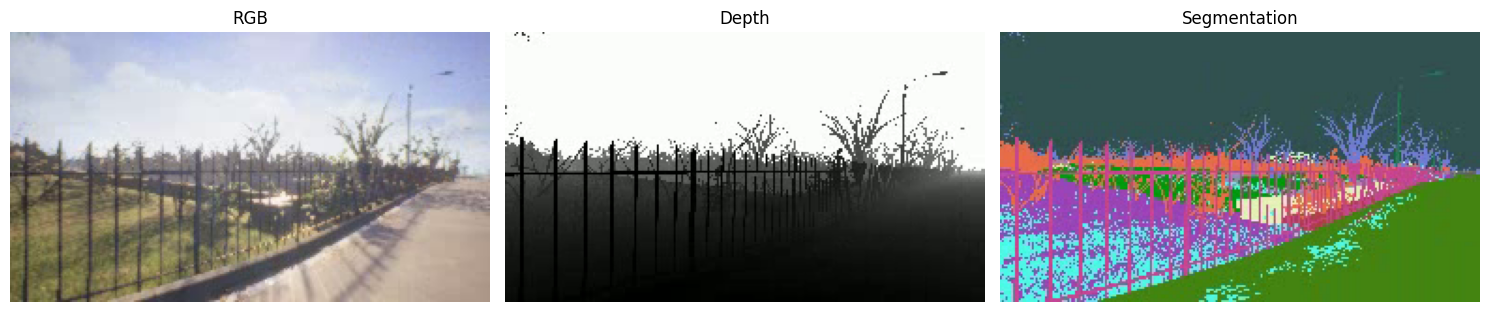

In [45]:
import matplotlib.pyplot as plt
def display_step(step_data):
    # grab frames
    rgb = step_data['video.rgb'][0]
    depth = step_data['video.depth'][0]
    seg  = step_data['video.segmentation'][0]

    # prepare images
    rgb_img   = rgb.astype('uint8') if rgb.dtype != np.uint8 else rgb
    depth_img = depth    # if float [0–1], you can plt.imshow(depth_img, cmap='gray')
    seg_img   = seg.astype('uint8') if seg.dtype != np.uint8 else seg

    # plot side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for ax, im, title in zip(axs, [rgb_img, depth_img, seg_img], ['RGB', 'Depth', 'Segmentation']):
        ax.imshow(im, cmap='gray' if title=='Depth' else None)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

display_step(step_data)

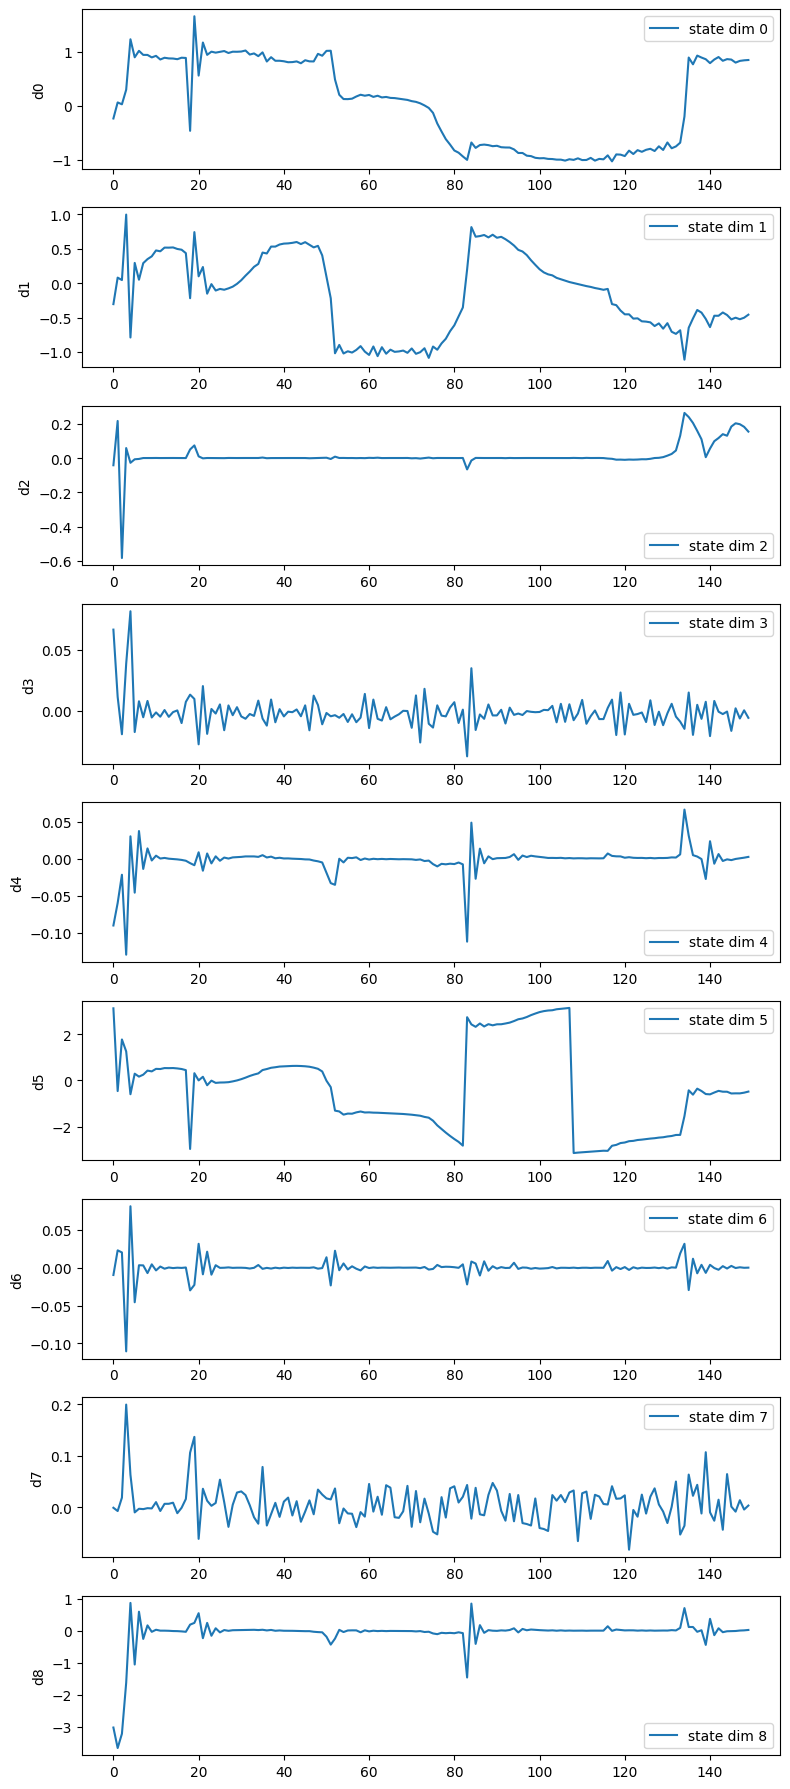

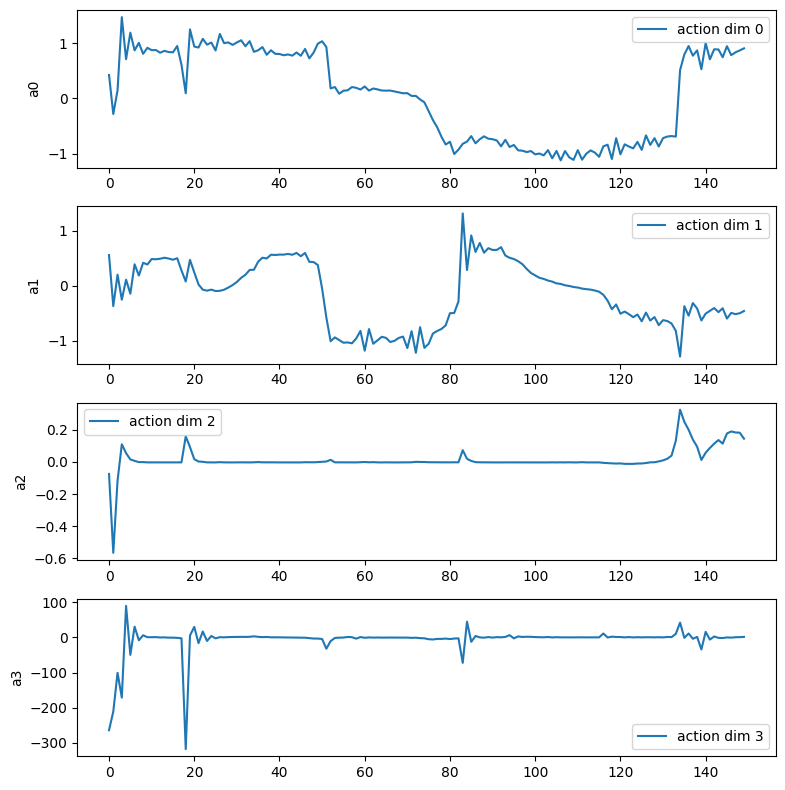

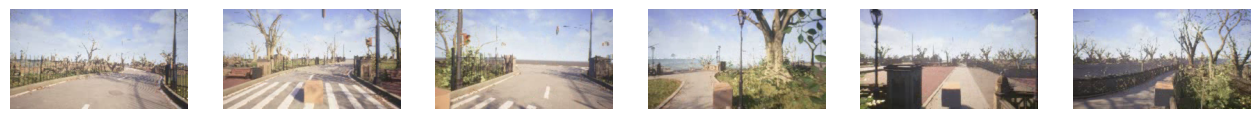

In [48]:
import numpy as np
import matplotlib.pyplot as plt

traj_id = 0
max_steps = 150
sample_images = 6

state_across_time = []
action_across_time = []
rgb_images = []

# assuming your dataset object is named `new_embodiment`
for step in range(max_steps):
    dp = dataset.get_step_data(traj_id, step)
    #print(dp)
    # extract drone state (9 dims) and action (4 dims)
    state = dp["state.drone_state"][0]           # shape (9,)
    
    action = dp["action.drone_action"][0]                      # shape (4,)
    
    state_across_time.append(state)
    action_across_time.append(action)
    
    # sample RGB frames evenly
    if step % (max_steps // sample_images) == 0:
        rgb = dp["video.rgb"][0]     # shape (H,W,3)
        rgb_images.append(rgb)

state_across_time = np.array(state_across_time)   # (max_steps, 9)
action_across_time = np.array(action_across_time) # (max_steps, 4)

# plot state dims
fig, axs = plt.subplots(nrows=9, figsize=(8, 2*9))
for i, ax in enumerate(axs):
    ax.plot(state_across_time[:, i], label=f"state dim {i}")
    ax.set_ylabel(f"d{i}")
    ax.legend()
plt.tight_layout()
plt.show()

# plot action dims
fig, axs = plt.subplots(nrows=4, figsize=(8, 2*4))
for i, ax in enumerate(axs):
    ax.plot(action_across_time[:, i], label=f"action dim {i}")
    ax.set_ylabel(f"a{i}")
    ax.legend()
plt.tight_layout()
plt.show()

# display sampled RGB frames
fig, axs = plt.subplots(1, sample_images, figsize=(16,4))
for i, ax in enumerate(axs):
    ax.imshow(rgb_images[i])
    ax.axis("off")
plt.show()

Let's plot just the "right hand" state and action data and see how it looks like. Also show the images of the right hand state.

Now we can run the policy from the pretrained checkpoint.

In [36]:
predicted_action = policy.get_action(step_data)
for key, value in predicted_action.items():
    print(key, value.shape, value)

action.drone_action (16, 4) [[  0.96716666   0.10585034  -0.05180013 -10.73471069]
 [  0.91118073   0.09891427  -0.06098163  -7.54818726]
 [  0.88318753   0.19818759  -0.06098163  -5.95492554]
 [  0.89718413   0.20555723  -0.04261863  -5.15829468]
 [  0.9251771    0.2463069   -0.06557238  -5.15829468]
 [  0.95666933   0.33430898  -0.07245839  -3.56503296]
 [  0.9986589    0.36248708  -0.06327701  -6.7515564 ]
 [  0.97766423   0.37202418  -0.05868626  -6.7515564 ]
 [  0.93567467   0.3572849   -0.07475376 -12.32800293]
 [  0.9391737    0.35988593  -0.03343725  -6.7515564 ]
 [  0.91467977   0.34991527  -0.07934451 -11.53134155]
 [  0.85519457   0.31480122  -0.06098163 -12.72631836]
 [  0.87618947   0.39543366  -0.06557238 -15.9128418 ]
 [  0.82370234   0.31956971  -0.06786776 -18.30273438]
 [  0.8202033    0.28749013  -0.08852601 -18.30273438]
 [  0.79745889   0.29616034  -0.08393526 -19.09936523]]


### Understanding the Action Output

Each joint in the action output has a shape of (16, N) where N is the degree of freedom for the joint.
- 16 represents the action horizon (predictions for timesteps t, t+1, t+2, ..., t+15)

For each arm (left and right):
- 7 arm joints:
  - Shoulder pitch
  - Shoulder roll
  - Shoulder yaw
  - Elbow pitch
  - Wrist yaw
  - Wrist roll
  - Wrist pitch

For each hand (left and right):
- 6 finger joints:
  - Little finger
  - Ring finger
  - Middle finger
  - Index finger
  - Thumb rotation
  - Thumb bending

For the waist
- 3 joints:
  - torso waist yaw
  - torso waist pitch
  - torso waist roll
